In [1]:
import torch
from torch import nn #nn contains all the building blocks for nn
import matplotlib.pyplot as plt

## Checking Pytorch version
torch.__version__

'2.0.1+cu118'

## 1. Data: Preparing (converting to tensor) and loading

Let's create some data to be used by the model. In this case a linear relationship

In [2]:
weight = 0.7
bias = 0.3

#creating data
start=0
end=1
step=0.02

X = torch.arange(start,end,step)
y = weight*X + bias

X[0:10]

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800])

Let's create our train and test data set

In [3]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Function to visualize

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

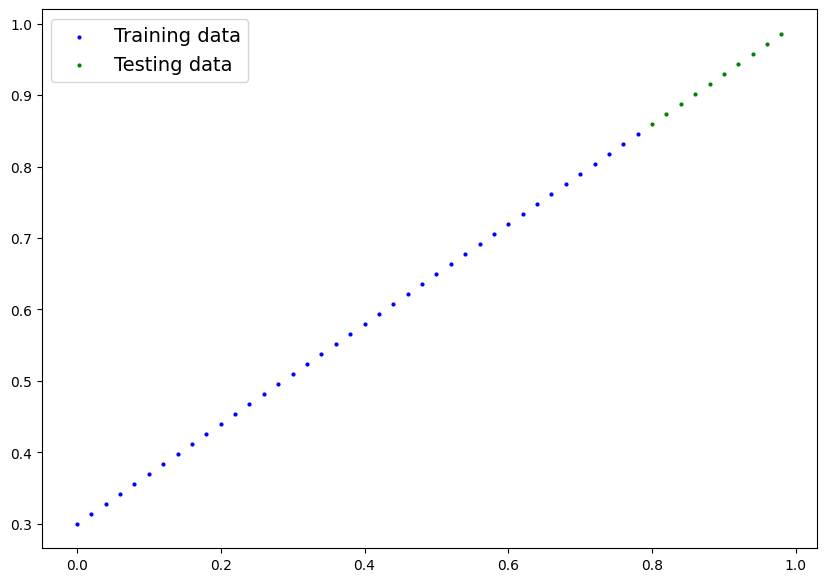

In [5]:
plot_predictions();

## Build a model

Standard linear regressor using Pytorch

In [13]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,dtype=torch.float),# <- start with random weights (this will get adjusted as the model learns)
                                requires_grad=True) # <- can we update this value with gradient descent?
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float),
                             requires_grad=True)

  #forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
    return self.weights*x + self.bias # <- this is the linear regression formula (y = m*x + b)


Checking the content of a Pytorch Model

In [8]:
torch.manual_seed(42)

In [15]:
# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

#check the nn.parameters within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.2345], requires_grad=True),
 Parameter containing:
 tensor([0.2303], requires_grad=True)]

We can also get the state (what the model contains) using '.state_dict()'

In [11]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Making predictions using "torch.inference_mode()"

In [16]:
with torch.inference_mode():
  y_preds = model_0(X_test)

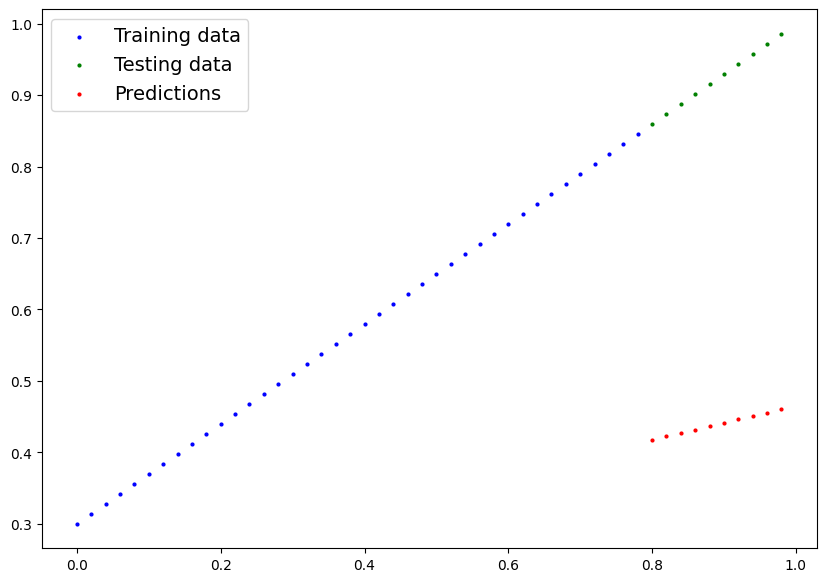

In [17]:
plot_predictions(predictions=y_preds)

### Train model

Creating a loss function and an optimizer in Pytorch

In [21]:
# create the loss function
loss_fn = nn.L1Loss() #MAE

# create the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)# parameters of target model to optimize
                             # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [22]:
epochs = 100

#Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  ### Training

  #put model in "training mode" (this is the default state of the model)
  model_0.train()

  #1. forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  #2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  #3. zero grad of the optimizer
  optimizer.zero_grad()

  #4. loss backwards
  loss.backward()

  #5. progress the optimizer
  optimizer.step()

  ############## Testing
  # put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    #1. forward pass on test data
    test_pred = model_0(X_test)

    #2. calculate loss on test data
    test_loss = loss_fn(test_pred,y_test.type(torch.float))

     # Print out what's happening
    if epoch % 10 == 0:
          epoch_count.append(epoch)
          train_loss_values.append(loss.detach().numpy())
          test_loss_values.append(test_loss.detach().numpy())
          print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.25122663378715515 | MAE Test Loss: 0.470524400472641 
Epoch: 10 | MAE Train Loss: 0.14193940162658691 | MAE Test Loss: 0.34090352058410645 
Epoch: 20 | MAE Train Loss: 0.09095562994480133 | MAE Test Loss: 0.2517372965812683 
Epoch: 30 | MAE Train Loss: 0.07409852743148804 | MAE Test Loss: 0.20021209120750427 
Epoch: 40 | MAE Train Loss: 0.06757690757513046 | MAE Test Loss: 0.17111757397651672 
Epoch: 50 | MAE Train Loss: 0.06348922103643417 | MAE Test Loss: 0.15400445461273193 
Epoch: 60 | MAE Train Loss: 0.05999922752380371 | MAE Test Loss: 0.14298436045646667 
Epoch: 70 | MAE Train Loss: 0.05650923401117325 | MAE Test Loss: 0.1319642961025238 
Epoch: 80 | MAE Train Loss: 0.05305762216448784 | MAE Test Loss: 0.12300487607717514 
Epoch: 90 | MAE Train Loss: 0.04962732270359993 | MAE Test Loss: 0.11541922390460968 


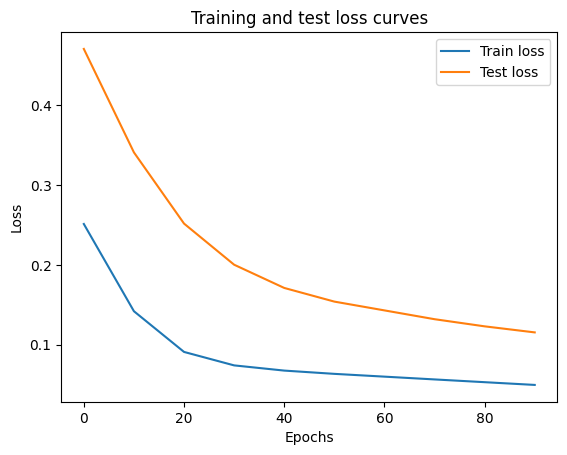

In [23]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [24]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.4701])), ('bias', tensor([0.3963]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Saving and loading a Pytorch model

In [25]:
from pathlib import Path

#1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [26]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Sep 14 10:08 models/01_pytorch_workflow_model_0.pth
